In [1]:
# Import libraries

# basic libraries
import pandas as pd
import numpy as np
import math

# data visualization
import matplotlib.pyplot as plt
from   matplotlib.pyplot import figure
import seaborn as sns
import geopandas as gpd
import folium
from branca.colormap import linear

# working with time series
import matplotlib.dates as mdates
from   datetime import date, time, datetime

# make sure each time the random generation gives the same result
np.random.seed(1234)

In [2]:
# import data sets
drivers = pd.read_csv("data_raw/drivers.csv")
driver_standings = pd.read_csv("data_raw/driver_standings.csv")
races = pd.read_csv("data_raw/races.csv")
constructors = pd.read_csv("data_raw/constructors.csv")
constructor_standings = pd.read_csv("data_raw/constructor_standings.csv")

In [3]:
# join drivers and driver standings

driver_join = pd.merge(drivers[["driverId", "forename", "surname", "nationality"]],
                       driver_standings[["raceId", "driverId", "points", "wins"]],
                       how = "left",
                       on = "driverId")

In [4]:
driver_join_21th = (pd.merge(driver_join,
                             races[["raceId", "year"]],
                             how = "left",
                             on = "raceId").query('year >= 2000'))

In [5]:
driver_nationality = (driver_join_21th.groupby("nationality")
                                      .agg(sum_wins_drivers = ("wins", "sum"))
                                      .query("sum_wins_drivers != 0")
                                      .sort_values("sum_wins_drivers", ascending = False)
                                      .reset_index())

<AxesSubplot: xlabel='sum_wins_drivers', ylabel='nationality'>

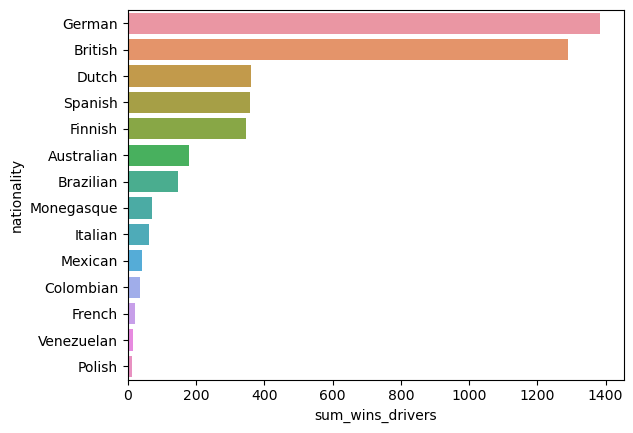

In [6]:
# Using seabron
sns.barplot(data = driver_nationality, y = "nationality", x = "sum_wins_drivers")

In [7]:
nationality_to_nation = {"British": "United Kingdom",
                         "German" : "Germany",
                         "Brazilian": "Brazil",
                         "French": "France",
                         "Finnish" : "Finland",
                         "Dutch" : "Denmark",
                         "Spanish": "Spain",
                         "Australian": "Australia",
                         "Italian" : "Italy",
                         "Monegasque" : "Monaco",
                         "Mexican" : "Mexico",
                         "Colombian" : "Colombia",
                         "Venezuelan" : "Venezuela",
                         "Polish" : "Poland"}

driver_nation = driver_nationality.replace(nationality_to_nation)

In [8]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

driver_nation_gpd = pd.merge(world, 
                             driver_nation, 
                             left_on = "name", 
                             right_on = "nationality", 
                             how = "inner")

In [9]:
driver_nation_map = folium.Map(location = [0, 0], zoom_start = 2)

folium.Choropleth(geo_data = driver_nation_gpd,
                  name = "choropleth",
                  data = driver_nation_gpd,
                  columns = ["nationality", "sum_wins_drivers"],
                  key_on = "feature.properties.name",
                  fill_color = "YlGn",
                  fill_opacity = 0.7,
                  line_opacity = 0.2,
                  legend_name = "sum_wins").add_to(driver_nation_map)

folium.GeoJson(
    driver_nation_gpd,
    name = "labels",
    style_function = lambda x: {
        "color": "black",
        "weight": 0.5,
        "fillOpacity": 0,
    },
    tooltip = folium.GeoJsonTooltip(fields = ["sum_wins_drivers"], aliases = ["Sum of Wins in 21th Century"]),
    highlight_function = lambda x: {
        "fillColor": "white",
        "color": "black",
        "weight": 1.5,
        "dashArray": "5, 5",
        "fillOpacity": 0.7,
    },
    show = True,
).add_to(driver_nation_map)

folium.LayerControl().add_to(driver_nation_map)

driver_nation_map

In [10]:
constructors_join = pd.merge(constructors[["constructorId", "nationality"]],
                             constructor_standings[["constructorId", "wins", "raceId"]],
                             on = "constructorId",
                             how = "inner")

In [11]:
constructors_21th = (pd.merge(constructors_join,
                              races[["raceId", "year"]],
                              on = "raceId",
                              how = "inner").query("year >= 2000"))

In [12]:
constructors_nationality = (constructors_21th.groupby("nationality")
                                             .agg(sum_wins_constructors = ("wins", "sum"))
                                             .query("sum_wins_constructors != 0")
                                             .sort_values("sum_wins_constructors", ascending = False)
                                             .reset_index())

In [13]:
constructors_drivers = pd.merge(driver_nationality,
                                constructors_nationality,                       
                                how = "inner",
                                on = "nationality")

<AxesSubplot: xlabel='sum_wins_drivers', ylabel='sum_wins_constructors'>

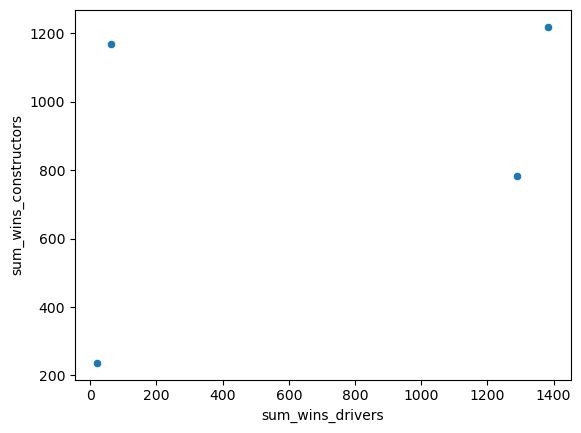

In [14]:
sns.scatterplot(x = "sum_wins_drivers", y = "sum_wins_constructors", data = constructors_drivers)